# Aprendizagem Automatica Avançada
### Assigment 8 - Interpretability
Ana Araújo 59457

Pedro Almeida 58844

### Content Table:
1. [Problem 1](#section1)
- 1.1 Mean Decrease in Impurity (MDI)
- 1.2 Permution Feature Importance
- 1.3 Differences between MDI and Permution feature Importance
- 1.4 SHAP and LIME

2. [Problem 2](#section2)
- 2.1 SHAP
- 2.2 SHAP vs LIME


In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


<a id='section1'></a>

## 1. Problem 1

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import shap
import lime
from shap import TreeExplainer
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data['feature_names']


In [ ]:
# Create a Pandas DataFrame from the dataset
df = pd.DataFrame(data.data, columns=data.feature_names)

# Display the first five rows of the DataFrame
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

Splitting data in training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### 1.1. Mean Decrease in Impurity (MDI)

In [ ]:
# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Analyze feature importance
feature_importances = clf.feature_importances_
sorted_idx = feature_importances.argsort()

In [ ]:
for idx in sorted_idx:
    print(f"{data.feature_names[idx]}: {feature_importances[idx]}")

mean symmetry: 0.00224725709606104
mean fractal dimension: 0.0034432040828194436
texture error: 0.0036381014979145047
smoothness error: 0.004002592837858134
symmetry error: 0.004028437124201361
concave points error: 0.004188048992588148
worst fractal dimension: 0.00450863381548871
mean smoothness: 0.006158137661274287
concavity error: 0.0065403064482547615
fractal dimension error: 0.007271178344516618
compactness error: 0.008337317499962906
worst symmetry: 0.009242863619752137
mean compactness: 0.011428608107625115
perimeter error: 0.01234567889966914
mean texture: 0.013717575459153765
radius error: 0.014687141339063512
worst smoothness: 0.015162483058655224
worst compactness: 0.019399293048165903
worst texture: 0.022721298542946564
area error: 0.025857092580351255
worst concavity: 0.04354026224254886
mean concavity: 0.04577025649873019
mean radius: 0.053385607023156194
mean perimeter: 0.06370066492162461
mean area: 0.0663696033672337
mean concave points: 0.07732620069321076
worst peri

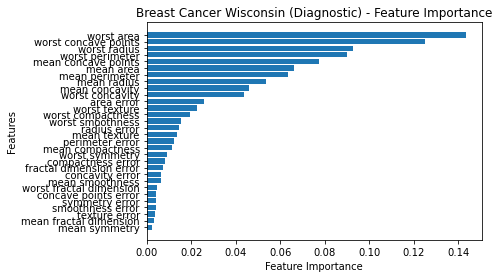

In [ ]:
# Create a horizontal bar chart of feature importances
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [data.feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Breast Cancer Wisconsin (Diagnostic) - Feature Importance")

plt.show()

The results obtained by this classifier using the  Mean Decrease in Impurity (MDI) present the features with the highest MDI values to the lowest. The features with the highest MDI values are the most important for the classifier to make accurate predictions. These features provide the most signigicant information about if a tumor is malignant or benign. The two feautures more importants are worst area and worst concave points.

The features with the lowest MDI values are the least important and can potentially be removed from the model without significantly impacting its performance. The mean symmetry, mean fractal dimension, texture error, smoothness error and symetry error are top 5 features less important.

### 1.2. Permutation Feature Importance

In [ ]:

r = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=0)


In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data.feature_names[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

####  1.2.1 For training slipt:

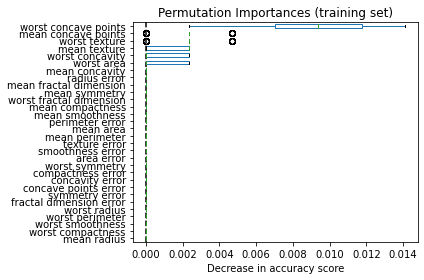

In [ ]:
result = permutation_importance(
    clf, X_train, y_train, n_repeats=100, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

#### For test split:

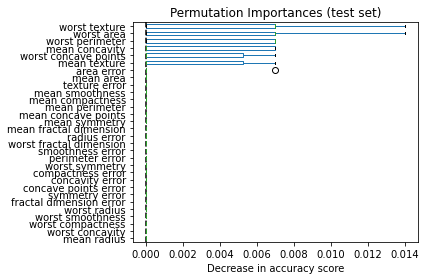

In [ ]:
result_test = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result_test.importances_mean.argsort()
importances = pd.DataFrame(
    result_test.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
print(f"RF train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {clf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.993


The Random Forest Classifier achieved a perfect accuracy of 100% on the training set, fiting perfectly the training data. Nevertheless, the test set presents an accuracy of 99.3%, being slightly lower than the training accuracy. This suggests that there may be some overfitting of the model to the training data.

### 1.3 Differences between MDI and Permutation Feature Importance

To verify the differences between MDI and Permutation Feature Importance, we are sorting by feature importance and observed the top 5 features for each approach.

In [ ]:
importance_mdi = clf.feature_importances_
importance_perm = result.importances_mean

In [ ]:
# Sort feature importance values in descending order
idx_mdi = importance_mdi.argsort()[::-1]
idx_perm = importance_perm.argsort()[::-1]

In [ ]:
# Compare the top 5 features based on the two methods
print("Top 5 features - MDI:")
for i in range(5):
    print(f"{i+1}. {data.feature_names[idx_mdi[i]]}: {importance_mdi[idx_mdi[i]]:.3f}")
print("\n")
print("Top 5 features - Permutation Feature Importance:")
for i in range(5):
    print(f"{i+1}. {data.feature_names[idx_perm[i]]}: {importance_perm[idx_perm[i]]:.3f}")

Top 5 features - MDI:
1. worst area: 0.143
2. worst concave points: 0.125
3. worst radius: 0.093
4. worst perimeter: 0.090
5. mean concave points: 0.077


Top 5 features - Permutation Feature Importance:
1. worst concave points: 0.009
2. mean concave points: 0.002
3. worst texture: 0.002
4. mean texture: 0.002
5. worst concavity: 0.001


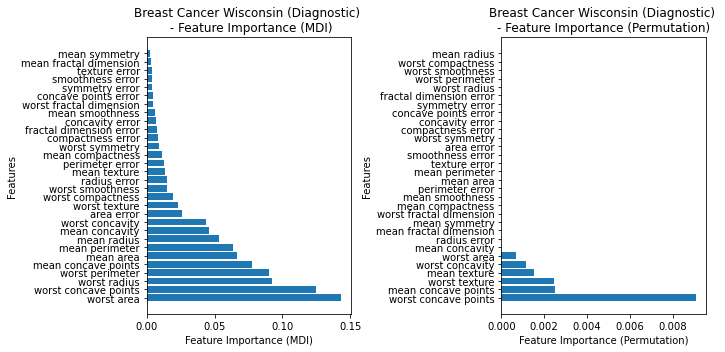

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Plot MDI feature importances
axes[0].barh(range(len(idx_mdi)), feature_importances[idx_mdi])
axes[0].set_yticks(range(len(idx_mdi)))
axes[0].set_yticklabels(data.feature_names[idx_mdi])
axes[0].set_xlabel("Feature Importance (MDI)")
axes[0].set_ylabel("Features")
axes[0].set_title("Breast Cancer Wisconsin (Diagnostic) \n - Feature Importance (MDI)")

# Plot permutation feature importances for the train set
axes[1].barh(range(len(idx_perm)), result.importances_mean[idx_perm])
axes[1].set_yticks(range(len(idx_perm)))
axes[1].set_yticklabels(data.feature_names[idx_perm])
axes[1].set_xlabel("Feature Importance (Permutation)")
axes[1].set_ylabel("Features")
axes[1].set_title("Breast Cancer Wisconsin (Diagnostic) \n- Feature Importance (Permutation)")

plt.tight_layout()
plt.show()

The features are sorted by their importance from top to bottom, and the bars represent the importance values.

By comparing the two subplots, we can see whether there are significant differences in the feature importance estimates between the two approaches.

Based on the MDI and Permutation Feature Importance approaches for feature importance estimation, we can conclude that the Random Forest Classifier trained on the Breast Cancer Wisconsin (Diagnostic) dataset places high importance on a few key features, including "worst concave points", "worst perimeter", "worst area", and "mean concave points".

The MDI approach shows that "worst area" is the most important feature, followed by "worst concave points", "worst radius", "worst perimeter" and "mean concave points". The Permutation Feature Importance approach for the training set shows that "worst concave points" is the most important feature, followed by "mean concave points", "worst texture", "mean texture" and "worst concavity".

The feature importance estimates are consistent between the two approaches, with the same features appearing at the top of the list. However, there are some differences in the relative importance of the features, which may be due to the different ways in which the two approaches compute feature importance.

### 1.4 SHAP and LIME

#### 1.4.1 SHAP:

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = TreeExplainer(clf)

# Compute shap_values for all of X_test rather instead of a single row, to have more data for plot
shap_values = explainer.shap_values(X_test)

**Summary plot for SHAP**

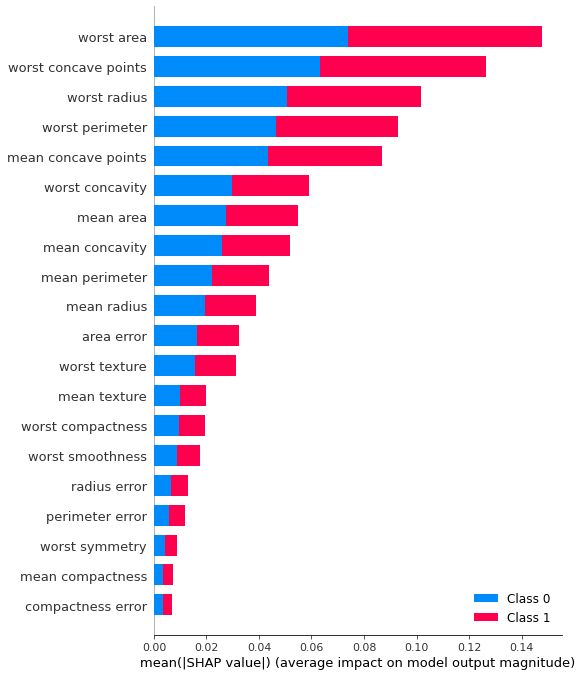

In [ ]:
# create a summary plot with custom axis labels
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names, plot_type='bar')



The summary plot generated by SHAP provides a global view of the impact that each feature has on the model output. The plot displays the feature importance values for each feature, which are calculated based on the mean absolute SHAP values. The features are sorted by importance, with the most important features at the top ("worst area", "worst concave points", "worst radius", "worst perimeter" and "mean concave points"). The color of each bar indicates whether the feature has high (red) or low values (blue). This plot can be helpful to identify which features are most important for the model and how they affect its predictions.

**Summary Plot on a specific label**

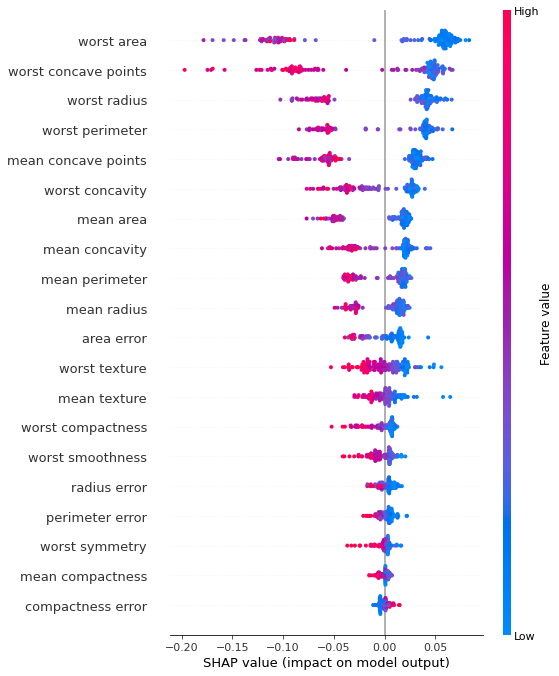

In [ ]:
# Summary Plot Deep-Dive on Label 1
shap.summary_plot(shap_values[1], X_test, feature_names=data.feature_names)

**Dependence Plot for the most mportant feature - "worst area"**

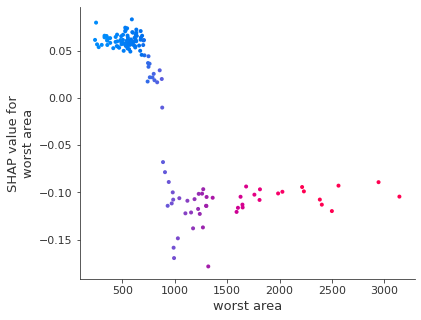

In [ ]:
# Dependence Plot on mean area
shap.dependence_plot('worst area', shap_values[1], X_test, feature_names=data.feature_names, interaction_index="worst area")

This plot shows that there is a positive relationship between "worst area" and the SHAP value for label 1, indicating that larger values of 'worst area' tend to increase the probability of predicting label 1. The plot also shows that the effect of "worst area" on the model prediction is relatively consistent across the range of feature values, which can indicat that there is no interaction effects with other features.

### 1.4.2 LIME

In [ ]:
# Get the class names
class_names = list(data.target_names)
# Print the class names
print(class_names)

['malignant', 'benign']


In [ ]:
# Create a Pandas DataFrame from X_train
df_train = pd.DataFrame(X_train, columns=data.feature_names)

# Get the feature names
feature_names = list(df_train.columns)

# Print the feature names
print(feature_names)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [ ]:
# Fit the explainer on the training dataset
explainer = LimeTabularExplainer(df_train.values, feature_names=feature_names,
                                 class_names=class_names, mode='classification')

**Single instance explanation**

In [ ]:
df_test = pd.DataFrame(X_test, columns=feature_names)
# Perform the explanation on the 8th instance in the test data
explanation = explainer.explain_instance(df_test.iloc[8], clf.predict_proba)

# Show the result of the model's explanation
explanation.show_in_notebook(show_table=True, show_all=False)

As per table presented above, the features "compactness error" and "worst radius" contribute negatively to the prediction, meaning that higher values of those features decrease the likelihood of the predicted class. While the remain feautures (the most important - worst texture) contribute positively to the prediction, meaning that higher values of those features increase the likelihood of the predicted class.

In this case, the  model prdicts the tumor being malignant with 39% of confidence, because the worst compactness error is low and and the worst radius is less than 15.05.

<a id='section2'></a>
## 2.  Problem 2

### 2.1 LIME and SHAP

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

In [ ]:
# Path to train and test directory
dir_ = os.path.join("C:/Users/pedro/Downloads/Aprendizagem Automatica Avançada/Assignment 8/animals")

In [ ]:
path = "C:/Users/pedro/Downloads/Aprendizagem Automatica Avançada/Assignment 8/animals"

if os.path.exists(path):
    print("The path exists.")
else:
    print("The path does not exist.")

The path exists.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 1920,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset = 'training')

Found 2400 images belonging to 3 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')

Found 600 images belonging to 3 classes.


In [ ]:
# Fetch the data and the labels
x_train_2, y_train_2 = next(train_generator)
x_test_2, y_test_2  = next(test_generator)

In [ ]:
# Fix the filepath
test_filepath = []
for filepath in test_generator.filepaths:
    filepath = filepath.replace('\\', '/')
    test_filepath.append(filepath)

Creating a Custom Model and Pre-trained InceptionV3 Model

In [ ]:
model = Sequential([

    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),

    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),

    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),

    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),

    # Output neuron.
        Dense(3, activation='softmax')
])

In [ ]:
# compile and train the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
      train_generator,
      epochs=80,
      verbose=1)

Epoch 1/80
2/2 [==============================] - 20s 1s/step - loss: 2.0408 - accuracy: 0.3242
Epoch 2/80
2/2 [==============================] - 13s 2s/step - loss: 0.9355 - accuracy: 0.5333
Epoch 3/80
2/2 [==============================] - 14s 10s/step - loss: 1.6862 - accuracy: 0.3333
Epoch 4/80
2/2 [==============================] - 14s 10s/step - loss: 1.4553 - accuracy: 0.3333
Epoch 5/80
2/2 [==============================] - 16s 11s/step - loss: 1.2405 - accuracy: 0.3333
Epoch 6/80
2/2 [==============================] - 15s 11s/step - loss: 1.1369 - accuracy: 0.3333
Epoch 7/80
2/2 [==============================] - 14s 10s/step - loss: 1.1104 - accuracy: 0.3333
Epoch 8/80
2/2 [==============================] - 13s 2s/step - loss: 1.1002 - accuracy: 0.3333
Epoch 9/80
2/2 [==============================] - 13s 2s/step - loss: 1.0633 - accuracy: 0.3333
Epoch 10/80
2/2 [==============================] - 13s 2s/step - loss: 1.0650 - accuracy: 0.3333
Epoch 11/80
2/2 [=================

In [ ]:
from tensorflow.keras.applications import inception_v3 as inc_net

### 2.1.1 LIME

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [ ]:
from skimage import io
import skimage
from tensorflow.keras.preprocessing import image

url = 'https://raw.githubusercontent.com/marcellusruben/All_things_medium/main/Lime/panda_00024.jpg'

def read_and_transform_img(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (100,100))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = read_and_transform_img(url)

preds = model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')

print(pct)

1/1 [==============================] - 0s 222ms/step
It's a panda!
0.8570385


In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


(-0.5, 99.5, 99.5, -0.5)

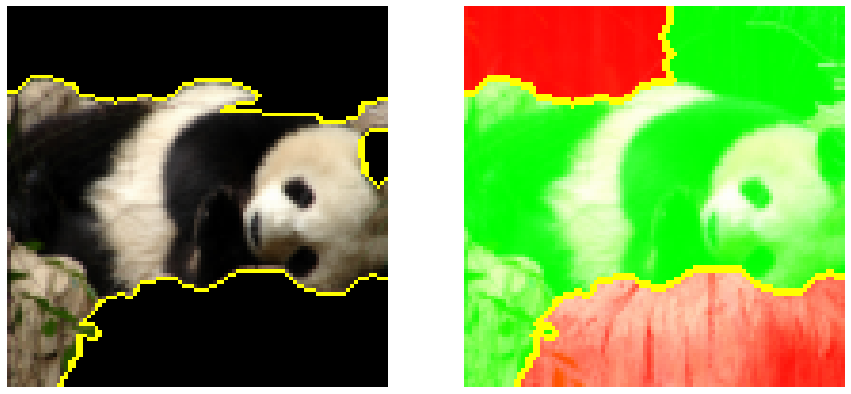

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def transform_img_fn_ori(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori(url)

1/1 [==============================] - 2s 2s/step
('n02510455', 'giant_panda', 0.9283559)
('n04266014', 'space_shuttle', 0.002729706)
('n04254680', 'soccer_ball', 0.00081451)
('n02002556', 'white_stork', 0.00065216346)
('n02509815', 'lesser_panda', 0.0006084182)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 391ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 298.5, 298.5, -0.5)

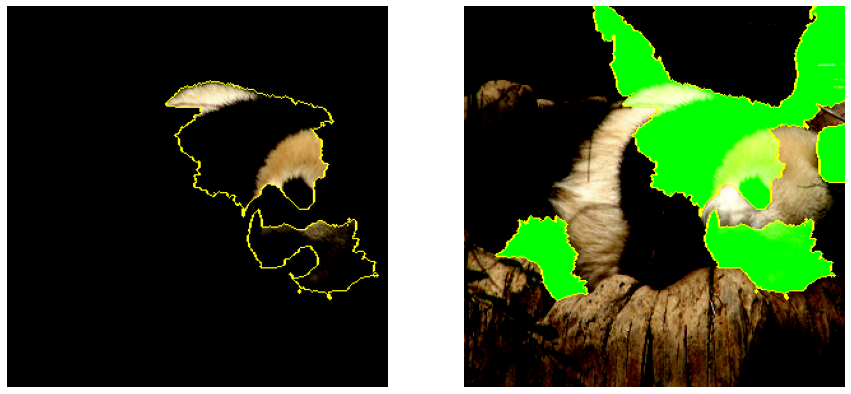

In [ ]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

### 2.1.2 SHAP

In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
def transform_img_fn_ori(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori(url)

1/1 [==============================] - 3s 3s/step
('n02510455', 'giant_panda', 0.9283559)
('n04266014', 'space_shuttle', 0.002729706)
('n04254680', 'soccer_ball', 0.00081451)
('n02002556', 'white_stork', 0.00065216346)
('n02509815', 'lesser_panda', 0.0006084182)


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [04:04, 244.39s/it]                                                                           
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


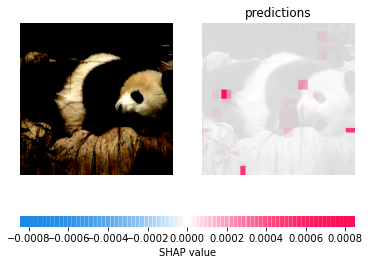

In [ ]:
from shap import Explainer, DeepExplainer
import cv2


# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", images_inc_im[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(inet_model, masker)


shap_values = explainer(images_inc_im[0:1], max_evals=1000, batch_size=5, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

### 2.2

In this particular case LIME seams to be better than SHAP, providing a better explanation on where the learning its happening.